## Imports

In [2]:
import numpy as np
import torch
import pickle
import matplotlib.pyplot as plt
from datetime import datetime



## Functions

In [3]:
def ReLU(h):
    indx = (h>0.)
    return indx*h, indx


class twoLayersModel:
    def __init__(self, n0, n1, n2):
        self.W1 = np.random.randn(n1, n0)/np.sqrt(n1)
        self.W2 = np.random.randn(n2, n1)/np.sqrt(n2)

    def __call__(self, x):
        h, indx1 = ReLU(np.matmul(self.W1, x))
        y, indx2 = ReLU(np.matmul(self.W2, h))

        W1px = self.W1 * indx1[:, None]
        W2px = self.W2 * indx2[:, None]

        Lambda_x = np.matmul(W2px, W1px)

        return y, Lambda_x

class threeLayersModel:
    def __init__(self, n0, n1, n2, n3):
        self.W1 = np.random.randn(n1, n0)/np.sqrt(n1)
        self.W2 = np.random.randn(n2, n1)/np.sqrt(n2)
        self.W3 = np.random.randn(n3, n2)/np.sqrt(n3)

    def __call__(self, x):
        h1, indx1 = ReLU(np.matmul(self.W1, x))
        h2, indx2 = ReLU(np.matmul(self.W2, h1))
        y, indx3 = ReLU(np.matmul(self.W3, h2))

        W1px = self.W1 * indx1[:, None]
        W2px = self.W2 * indx2[:, None]
        W3px = self.W3 * indx3[:, None]

        Lambda_x = np.matmul(W3px, np.matmul(W2px, W1px))

        return y, Lambda_x

In [4]:
def flipped_GD_CS_run(net, A, b, x_t, ystar, xstar,
                      learning_rate=0.1, num_steps=50000, 
                      path=None, verbose = 0, stopping = True):

    iter_idx = 0

    nrm_ystar = np.linalg.norm(ystar, 2)
    nrm_xstar = np.linalg.norm(xstar, 2)

    loss_func = []
    relError_x = []
    relError_y = []


    # Step 0, logs
    y_t, Lambda_x_t = net(x_t)
    residual_t = np.matmul(A, y_t) - b
    loss_t = (residual_t**2).sum()/2

    loss_func.append(loss_t)
    relError_x.append(np.linalg.norm(x_t - xstar,2)/nrm_xstar)
    relError_y.append(np.linalg.norm(y_t - ystar,2)/nrm_ystar)

    grad_flag = False

    while iter_idx < num_steps and grad_flag == False:

        # Negation step
        y2, Lambda2_x_t = net(-x_t)
        residual2 = np.matmul(A, y2) - b
        loss2 = (residual2**2).sum()/2

        if(loss2 < loss_t):
            x_t = -x_t
            y_t = y2
            residual_t = residual2
            Lambda_x_t = Lambda2_x_t

        # GD step
        Omega = np.matmul(Lambda_x_t.T, A.T)
        grad_t = np.matmul(Omega, residual_t)
        x_t = x_t - learning_rate*grad_t

        # Logs
        y_t, Lambda_x_t = net(x_t)
        residual_t = np.matmul(A, y_t) - b
        loss_t = (residual_t**2).sum()/2

        loss_func.append(loss_t)
        relError_x.append(np.linalg.norm(x_t - xstar,2)/nrm_xstar)
        relError_y.append(np.linalg.norm(y_t - ystar,2)/nrm_ystar)

        iter_idx += 1 

        if verbose>1:
            if (iter_idx%100 == 0):
                print('Iteration', iter_idx)
                print('Loss_func', loss_func[-1])
                print('RelError_x',relError_x[-1])
                print('RelError_y',relError_y[-1])
                print('Grad norm', np.linalg.norm(grad_t))
                print('*---------------*')

        if(stopping):
            if(np.linalg.norm(grad_t) < 1e-10):
                grad_flag = True
        

    print('Number of iterations', iter_idx)

    LOGS = {}
    LOGS['loss_func'] = np.array(loss_func)
    LOGS['relError_x'] = np.array(relError_x)
    LOGS['relError_y'] = np.array(relError_y)

    if verbose>0:
        print('Final loss_func', LOGS['loss_func'][-1])
        print('Final relError_x', LOGS['relError_x'][-1])
        print('Final relError_y', LOGS['relError_y'][-1])
        print('*---------------*')

    if(path != None):
        with open(path, 'wb') as handle:
            pickle.dump(LOGS, handle, protocol=pickle.HIGHEST_PROTOCOL)

    return [LOGS, x_t]

In [5]:
def run_experiments(num_runs, layers, m, eta, learning_rate=.7, num_steps=10000, path = None):

    loss_func_vec = np.zeros(num_runs)
    relError_x_vec = np.zeros(num_runs)
    relError_y_vec = np.zeros(num_runs)

    for j in range(num_runs):

        if(len(layers) == 3):
            n0, n1, n2 = layers
            GenNet = twoLayersModel(n0, n1, n2)
            A = np.random.randn(m, n2)/np.sqrt(m)
        else:
            n0, n1, n2, n3 = layers
            GenNet = threeLayersModel(n0, n1, n2, n3)
            A = np.random.randn(m, n3)/np.sqrt(m)
        
        # target latent vector
        xstar = np.zeros(n0) 
        xstar[1] = 1 # the target point is zstar = e_2

        # target vector in the range of G
        ystar, _ = GenNet(xstar)
        # scale it so that ystar is unit norm (use homogeneity)
        xstar = xstar/np.linalg.norm(ystar)
        ystar, _ = GenNet(xstar)

        # noisy random linear measurements
        b = np.matmul(A, ystar) + eta

        # random initialization
        x_t = np.random.randn(n0)
        # recovery algorithm
        [LOGS, x_t] = flipped_GD_CS_run(GenNet, A, b, x_t, ystar, xstar,
                      learning_rate=learning_rate, num_steps=num_steps, 
                      path=None, verbose = 0, stopping = True)


        loss_func_vec[j] = LOGS['loss_func'][-1]
        relError_x_vec[j] = LOGS['relError_x'][-1]
        relError_y_vec[j] = LOGS['relError_y'][-1]

    LOGs_runs = {}
    LOGs_runs['loss_func_mean'] = loss_func_vec.mean()
    LOGs_runs['loss_func_std'] = loss_func_vec.std()

    LOGs_runs['relError_x_mean'] = relError_x_vec.mean()
    LOGs_runs['relError_x_std'] = relError_x_vec.std()
    LOGs_runs['prob_recovery_x'] = (relError_x_vec < 1e-3).mean()
    
    LOGs_runs['relError_y_mean'] = relError_y_vec.mean()
    LOGs_runs['relError_y_std'] = relError_y_vec.std()
    LOGs_runs['prob_recovery_y'] = (relError_y_vec < 1e-3).mean()

    return LOGs_runs

## Experiments

### Errors (noisey)

In [6]:
num_runs = 30
n1, n2 =  700, 600
m = 300
etilde = np.random.randn(m) 
num_steps = 20000
learning_rate = 0.7
N0s = [15, 20, 25, 30, 35, 40, 45]

#### Two Layers, SNR = 80

In [19]:
tau = 1e-8
eta = tau*etilde/np.linalg.norm(etilde)

In [20]:
summary_res = []
start = datetime.now()

for n0 in N0s:
    print('------------')
    print(n0)
    layers = [n0, n1, n2]
    summary_res.append(run_experiments(num_runs, layers, m, eta, learning_rate=learning_rate, num_steps=num_steps, path = None))

delta = datetime.now() - start
print("Execution time", delta)

------------
5
Number of iterations 170
Number of iterations 163
Number of iterations 160
Number of iterations 166
Number of iterations 158
Number of iterations 164
Number of iterations 177
Number of iterations 182
Number of iterations 134
Number of iterations 170
Number of iterations 214
Number of iterations 135
Number of iterations 156
Number of iterations 168
Number of iterations 163
Number of iterations 143
Number of iterations 145
Number of iterations 162
Number of iterations 170
Number of iterations 187
Number of iterations 161
Number of iterations 188
Number of iterations 191
Number of iterations 165
Number of iterations 156
Number of iterations 160
Number of iterations 214
Number of iterations 164
Number of iterations 173
Number of iterations 173
------------
10
Number of iterations 218
Number of iterations 192
Number of iterations 230
Number of iterations 225
Number of iterations 191
Number of iterations 190
Number of iterations 198
Number of iterations 177
Number of iteration

In [21]:
summary_res_SNR80 = summary_res
path = './results/experiment_2_v2/summary_res_SNR80.pkl'
with open(path, 'wb') as handle:
    pickle.dump(summary_res_SNR80, handle, protocol=pickle.HIGHEST_PROTOCOL)

print(len(summary_res_SNR80))

9


#### Two Layers, SNR = 40

In [16]:
tau = 1e-4
eta = tau*etilde/np.linalg.norm(etilde)

In [17]:
summary_res = []
start = datetime.now()

for n0 in N0s:
    print('------------')
    print(n0)
    layers = [n0, n1, n2]
    summary_res.append(run_experiments(num_runs, layers, m, eta, learning_rate=learning_rate, num_steps=num_steps, path = None))

delta = datetime.now() - start
print("Execution time", delta)

------------
5
Number of iterations 143
Number of iterations 209
Number of iterations 169
Number of iterations 219
Number of iterations 155
Number of iterations 186
Number of iterations 139
Number of iterations 186
Number of iterations 152
Number of iterations 160
Number of iterations 182
Number of iterations 143
Number of iterations 179
Number of iterations 157
Number of iterations 145
Number of iterations 141
Number of iterations 187
Number of iterations 196
Number of iterations 153
Number of iterations 176
Number of iterations 162
Number of iterations 145
Number of iterations 172
Number of iterations 156
Number of iterations 141
Number of iterations 172
Number of iterations 160
Number of iterations 213
Number of iterations 160
Number of iterations 160
------------
10
Number of iterations 206
Number of iterations 193
Number of iterations 253
Number of iterations 195
Number of iterations 210
Number of iterations 209
Number of iterations 206
Number of iterations 226
Number of iteration

In [18]:
summary_res_SNR40 = summary_res
path = './results/experiment_2_v2/summary_res_SNR40.pkl'
with open(path, 'wb') as handle:
    pickle.dump(summary_res_SNR40, handle, protocol=pickle.HIGHEST_PROTOCOL)

print(len(summary_res_SNR40))

9


#### Two Layers, SNR = 20

In [25]:
tau = 1e-2
eta = tau*etilde/np.linalg.norm(etilde)

In [26]:
summary_res = []
start = datetime.now()

for n0 in N0s:
    print('------------')
    print(n0)
    layers = [n0, n1, n2]
    summary_res.append(run_experiments(num_runs, layers, m, eta, learning_rate=learning_rate, num_steps=num_steps, path = None))

delta = datetime.now() - start
print("Execution time", delta)

------------
5
Number of iterations 201
Number of iterations 150
Number of iterations 156
Number of iterations 179
Number of iterations 204
Number of iterations 165
Number of iterations 175
Number of iterations 185
Number of iterations 150
Number of iterations 140
Number of iterations 143
Number of iterations 175
Number of iterations 193
Number of iterations 171
Number of iterations 168
Number of iterations 185
Number of iterations 149
Number of iterations 195
Number of iterations 164
Number of iterations 221
Number of iterations 172
Number of iterations 196
Number of iterations 181
Number of iterations 155
Number of iterations 165
Number of iterations 150
Number of iterations 153
Number of iterations 144
Number of iterations 162
Number of iterations 170
------------
10
Number of iterations 50000
Number of iterations 199
Number of iterations 50000
Number of iterations 201
Number of iterations 215
Number of iterations 230
Number of iterations 50000
Number of iterations 199
Number of ite

In [27]:
summary_res_SNR20 = summary_res
path = './results/experiment_2_v2/summary_res_SNR20.pkl'
with open(path, 'wb') as handle:
    pickle.dump(summary_res_SNR20, handle, protocol=pickle.HIGHEST_PROTOCOL)

print(len(summary_res_SNR20))

9


### Analysis

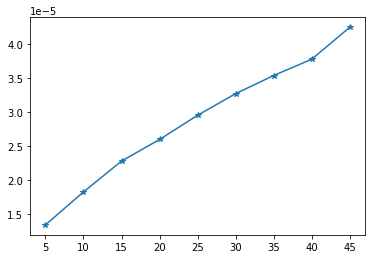

In [36]:
relError_y_mean_SNR40 = []

for res in summary_res_SNR40:
    relError_y_mean_SNR40.append(res['relError_y_mean'])

plt.plot(N0s, relError_y_mean_SNR40, '-*')

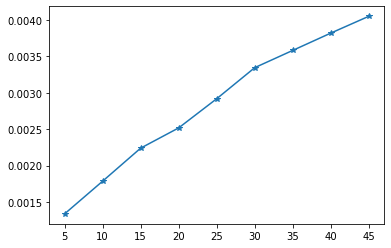

In [38]:
relError_y_mean_SNR20 = []

for res in summary_res_SNR20:
    relError_y_mean_SNR20.append(res['relError_y_mean'])

plt.plot(N0s, relError_y_mean_SNR20, '-*')

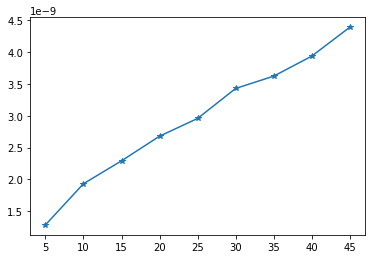

In [39]:
relError_y_mean_SNR80 = []

for res in summary_res_SNR80:
    relError_y_mean_SNR80.append(res['relError_y_mean'])

plt.plot(N0s, relError_y_mean_SNR80, '-*')

In [ ]:
summary_res_SNR40
relError_y_mean_SNR40 = []

for res in summary_res_SNR20:
    relError_y_mean_SNR20.append(res['relError_y_mean'])

plt.plot(N0s, relError_y_mean_SNR20, '-*')